# Gaussian Process Regression for Ground Temperature Prediction

Here, the goal is to predict ground temperature at 2m depth using a GP built specifically for this target variable (other temperature depths also valid).

Main reason, is that we know that atmospheric temperature and altitude are near-linear predictors of ground temperature, so we can use kernels specific to these features. 


# What I've tried

- vanilla radial basis function kernel for all features
- instead of constant mean for all features use linear mean for temperature and altitude when estimating ground temperature
- use a categorical feature kernel for stratigraphy index
- when applying this to active layer thickness, scores went down quite a bit (0.9 down to 0.5)

## Things to try

- [ ] estimate temperatures at different depths for summer and winter instead of trying to estimate active layer thickness, use winter and summer temperatures (mean, 10th%, 90th%) etc.
- [ ] add [summer, winter, spring, autumn], [temperatures, precipitation] as features

## Changes to make 
- [ ] Go with constant mean rather than linear mean
- [ ] Use polynomial kernel for temperature and altitude (power 2/3)
- [ ] Use RBF for rest

# Imports

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
## general libraries
import pathlib
from rich.pretty import install

## data handling libraries
import pandas as pd
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask

# plotting libraries
import matplotlib.pyplot as plt

## machine learning libraries
import gpytorch as gp
# import torch

## PAMIR libraries
import pamir_mlpermafrost as pamir

install(overflow=True)

# Loading Config

In [8]:
config_dir = str(pathlib.Path('../src/pamir_mlpermafrost/conf').resolve())
config_name = 'laptop-jupyter'

In [9]:
cfg = pamir.utils.load_hydra_config(config_dir, config_name)

# Training model 

In [147]:
data = cfg.data.training.load()
data_X, data_y = cfg.preprocessing.training(data)

train_X, test_X, train_y, test_y = cfg.preprocessing.train_test_split(data_X, data_y)

In [148]:
scaler_X = cfg.scalers.features.fit(train_X)
scaler_y = cfg.scalers.target.fit(train_y.to_frame())

train_X_scaled = scaler_X.transform(train_X)
train_y_scaled = scaler_y.transform(train_y.to_frame()).squeeze()

test_X_scaled = scaler_X.transform(test_X)
test_y_scaled = scaler_y.transform(test_y.to_frame()).squeeze()

In [149]:
model = cfg.model(
    train_X_scaled, 
    train_y_scaled).to(cfg.device)

model

2025-08-06 15:16:31.742 | INFO     | models:__init__:91 - categories=tensor([1., 2., 3., 4.])



GPMixedMeanCatIndex(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ProductKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): IndexKernel(
        (raw_var_constraint): Positive()
      )
    )
  )
  (linear_mean): LinearMean()
  (constant_mean): ConstantMean()
)

In [150]:
model, scores = model.fit(
    train_X_scaled, 
    train_y_scaled, 
    cfg.optimizer(model.parameters()),
    n_iters=500,
    patience=10, 
    tolerance=5e-3,
)

2025-08-06 15:16:33.305 | DEBUG    | train:train_mll:50 - Iter 1/500 - Loss: 2.344675
2025-08-06 15:16:33.798 | DEBUG    | train:train_mll:50 - Iter 2/500 - Loss: 2.318494
2025-08-06 15:16:34.287 | DEBUG    | train:train_mll:50 - Iter 3/500 - Loss: 2.292510
2025-08-06 15:16:34.766 | DEBUG    | train:train_mll:50 - Iter 4/500 - Loss: 2.268194
2025-08-06 15:16:35.241 | DEBUG    | train:train_mll:50 - Iter 5/500 - Loss: 2.244258
2025-08-06 15:16:35.721 | DEBUG    | train:train_mll:50 - Iter 6/500 - Loss: 2.218424
2025-08-06 15:16:36.216 | DEBUG    | train:train_mll:50 - Iter 7/500 - Loss: 2.195401
2025-08-06 15:16:36.696 | DEBUG    | train:train_mll:50 - Iter 8/500 - Loss: 2.177376
2025-08-06 15:16:37.171 | DEBUG    | train:train_mll:50 - Iter 9/500 - Loss: 2.153490
2025-08-06 15:16:37.648 | INFO     | train:train_mll:48 - Iter 10/500 - Loss: 2.134845
2025-08-06 15:16:38.138 | DEBUG    | train:train_mll:50 - Iter 11/500 - Loss: 2.113538
2025-08-06 15:16:38.629 | DEBUG    | train:train_mll

In [151]:
scores_train = model.score(train_X_scaled, train_y_scaled, scaler_y)
scores_test = model.score(test_X_scaled, test_y_scaled, scaler_y)

pd.DataFrame({
    'train': scores_train,
    'test': scores_test
}).rename(index=lambda x: x.upper()).round(2)

train  test
MSE    0.32  1.11
RMSE   0.56  1.05
MAE    0.39  0.73
R2     0.96  0.87

# Inference 

In [138]:
ds_spatial = cfg.data.inference.load().isel(y=slice(0, 1000), x=slice(0, 1000))

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/numcodecs/zarr3.py:145: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


In [139]:
url = "simplecache::s3://spi-pamir-cryogrid/pamir-MLpermafrost/data-inference/inference_variables-710w365s750e400n-100m.zarr/"
# storage_options = pamir.data.s3_utils.fsspec_kwargs
# ds_spatial = xr.open_zarr(url, storage_options=storage_options)

In [140]:
fname_cryogrid = '../../pamir-CryoGrid/output/cluster_config-k1500-pamir_S180-exp1.zarr/'

da_cluster_labels = (
    xr.open_zarr(fname_cryogrid, consolidated=True)
    .cluster_labels
    .isel(y=slice(0, 1000), x=slice(0, 1000))
    .compute()
)

# ds_spatial = xr.open_zarr(url, storage_options=storage_options).isel(x=slice(0, 2000), y=slice(-2000, None))
mask = (
    (ds_spatial.altitude > 3100)
    &
    (ds_spatial.surface_index > 0)
)

In [141]:
from functools import partial

dataset = pamir.preprocessing.datasets.DatasetXarraySpatial(
    ds_spatial.chunk({'y': 100, 'x': 100}),
    chunk_processor=partial(pamir.data.processors.process_X, features=cfg.features),
    scaler=scaler_X,
)

In [142]:
yhat_avg, yhat_std = pamir.models.gp.inference.predict(
    model, dataset, scaler_y
)

yhat_avg = dataset.reconstruct_output(yhat_avg)
yhat_std = dataset.reconstruct_output(yhat_std)

2025-08-06 15:14:21.937 | INFO     | <string>:predict:6 - Preparing datasets
2025-08-06 15:14:21.938 | INFO     | <string>:predict:10 - starting inference
2025-08-06 15:14:30.017 | INFO     | <string>:predict:21 - Processed batch 1/100
2025-08-06 15:14:30.292 | INFO     | <string>:predict:21 - Processed batch 2/100
2025-08-06 15:14:30.527 | INFO     | <string>:predict:21 - Processed batch 3/100
2025-08-06 15:14:30.758 | INFO     | <string>:predict:21 - Processed batch 4/100
2025-08-06 15:14:30.983 | INFO     | <string>:predict:21 - Processed batch 5/100
2025-08-06 15:14:31.217 | INFO     | <string>:predict:21 - Processed batch 6/100
2025-08-06 15:14:31.439 | INFO     | <string>:predict:21 - Processed batch 7/100
2025-08-06 15:14:31.662 | INFO     | <string>:predict:21 - Processed batch 8/100
2025-08-06 15:14:31.887 | INFO     | <string>:predict:21 - Processed batch 9/100
2025-08-06 15:14:32.110 | INFO     | <string>:predict:21 - Processed batch 10/100
2025-08-06 15:14:32.340 | INFO    

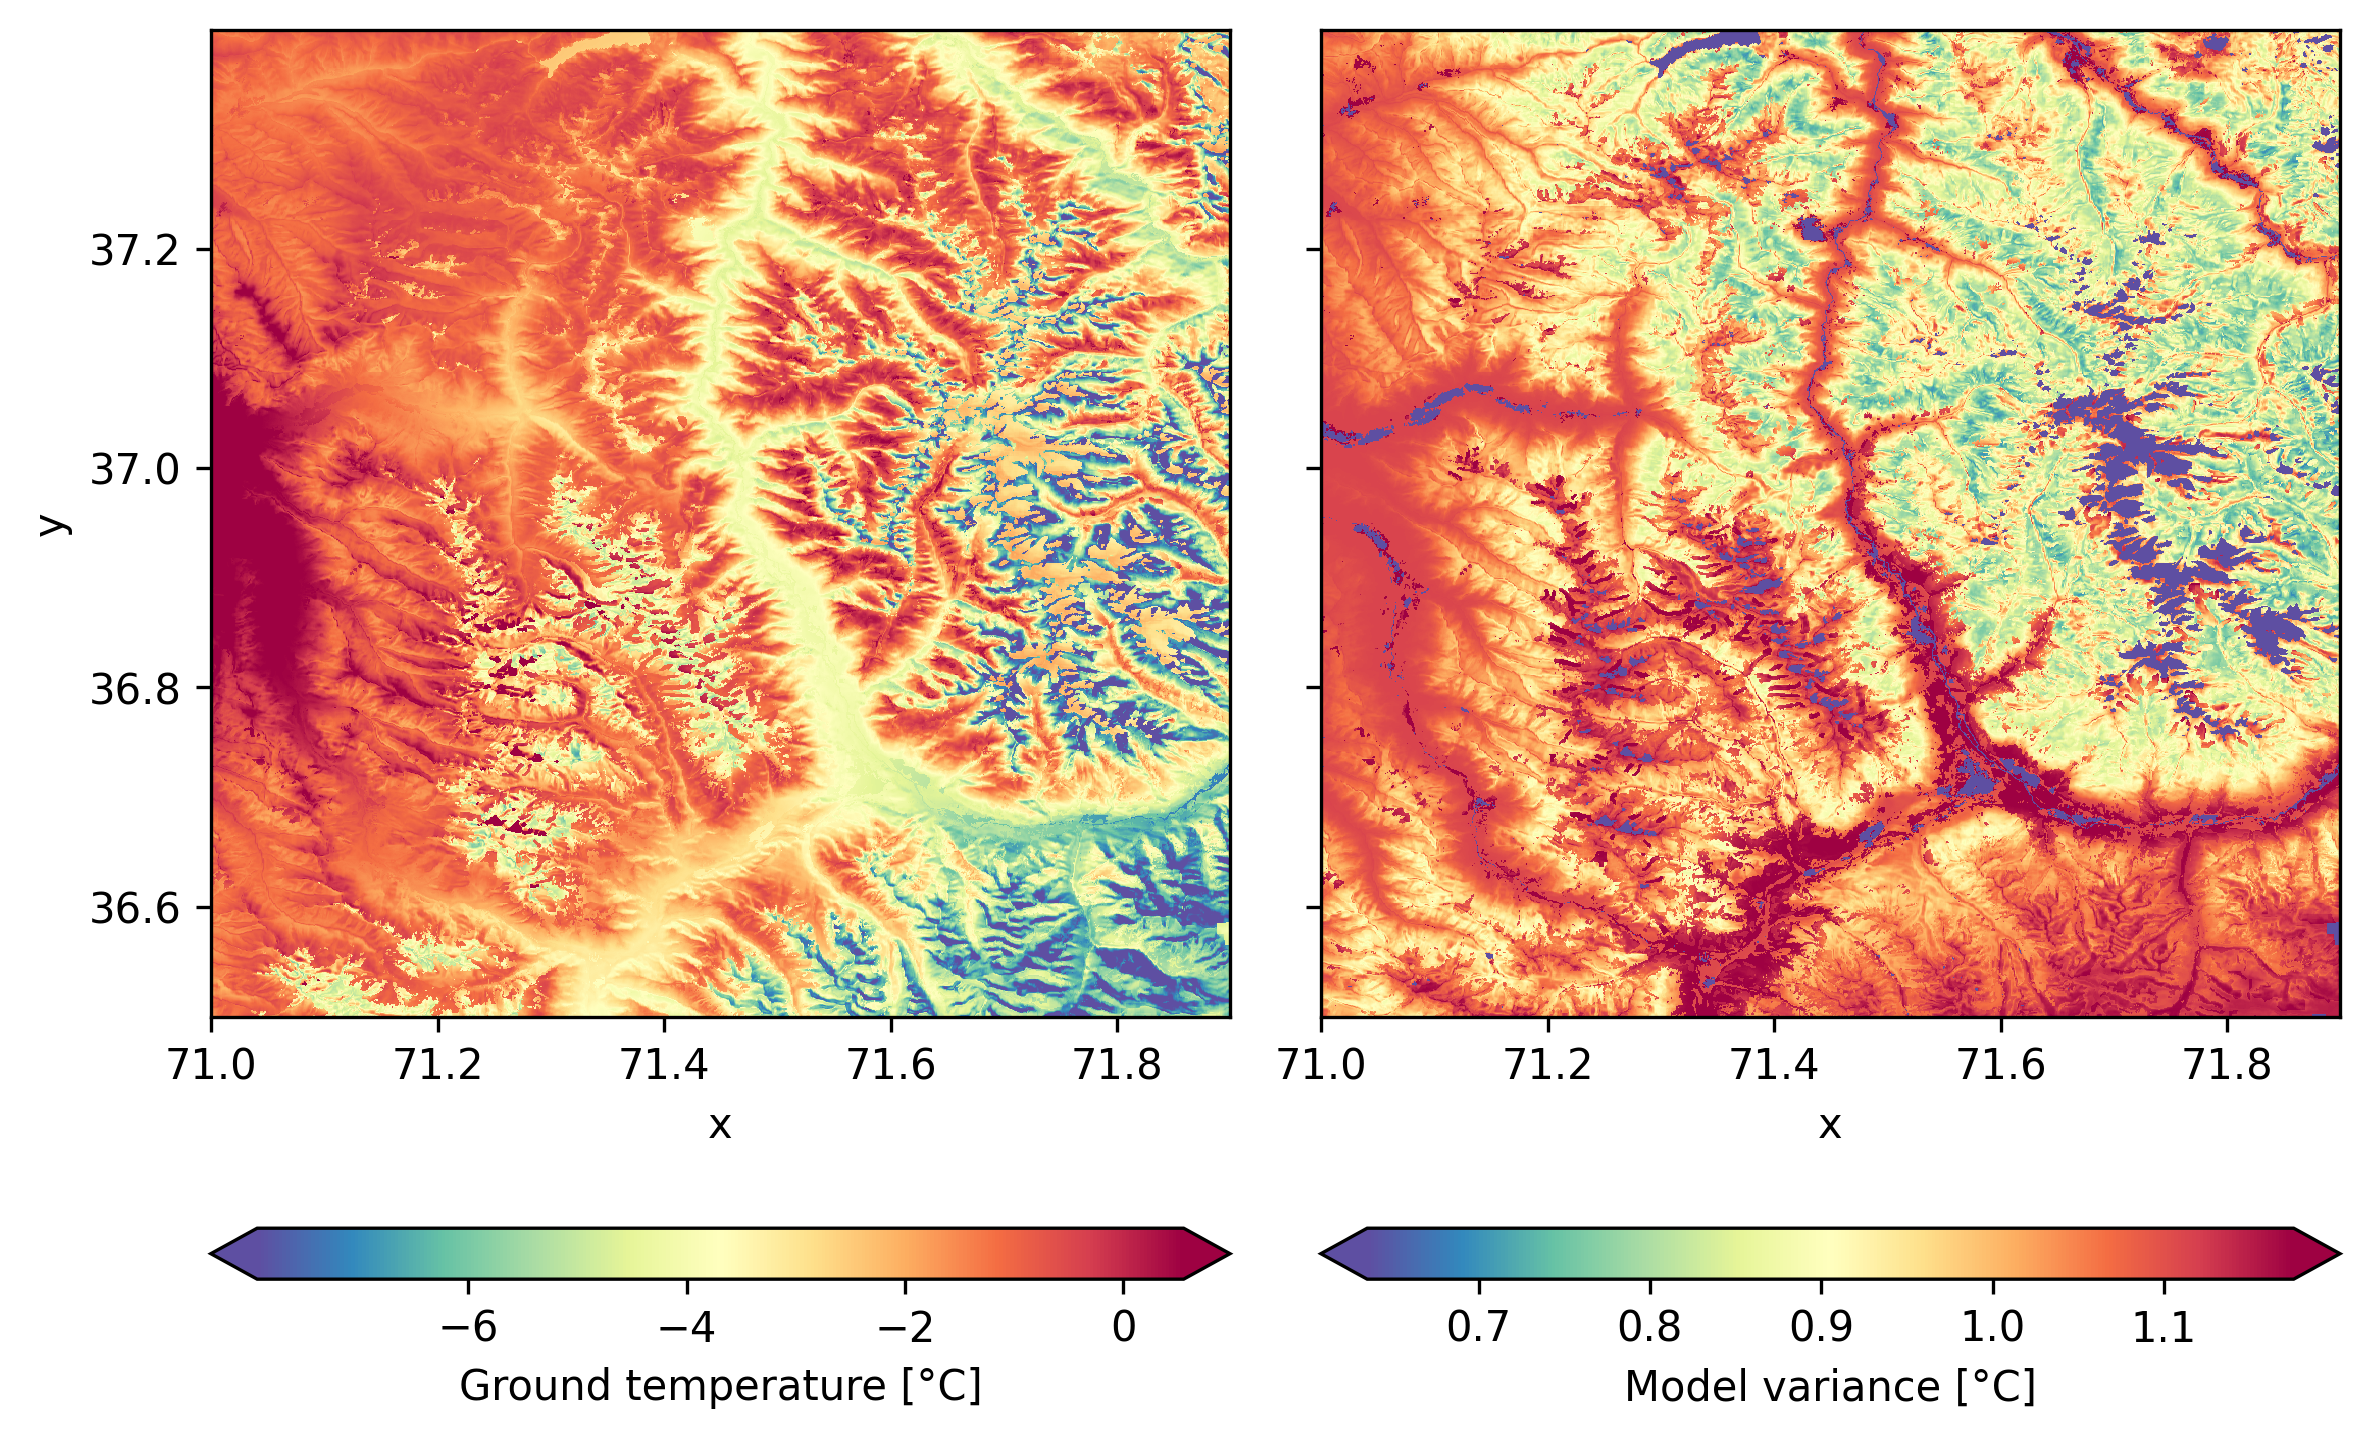

In [144]:
# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=300, sharex=True, sharey=True)

img0 = (
    yhat_avg
    # .where(lambda x: x<0)
    # .where(mask)
    .plot.imshow(
        ax=ax[0],
        cmap='Spectral_r', 
        robust=True,
        center=False,
        cbar_kwargs={'orientation': 'horizontal', 'label': 'Ground temperature [°C]'}
    ))

img1 = (
    yhat_std
    # .where(lambda x: x<0)
    # .where(mask)
    .plot.imshow(   
        ax=ax[1],
        cmap='Spectral_r', 
        robust=True,
        center=False,
        cbar_kwargs={'orientation': 'horizontal', 'label': 'Model variance [°C]'}
    ))

ax[1].set_ylabel('')

fig.tight_layout()